# Logistic Regression with PySpark

In [1]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [5]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read File

In [7]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("diabetes.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 768 rows 9 columns in the data.


## Show Sample Data

In [8]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 4 rows



## Data Types of Columns

In [9]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



## Statistics

In [10]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


from pyspark.sql.functions import when
df=df.withColumn("Glucose",when(df.Glucose==0,np.nan).otherwise(df.Glucose))
df=df.withColumn("BloodPressure",when(df.BloodPressure==0,np.nan).otherwise(df.BloodPressure))
df=df.withColumn("SkinThickness",when(df.SkinThickness==0,np.nan).otherwise(df.SkinThickness))
df=df.withColumn("BMI",when(df.BMI==0,np.nan).otherwise(df.BMI))
df=df.withColumn("Insulin",when(df.Insulin==0,np.nan).otherwise(df.Insulin))

from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(df)
raw_data=model.transform(df)
raw_data.show(5)

## Target Variable Distribution

In [11]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



## Distribution of Features

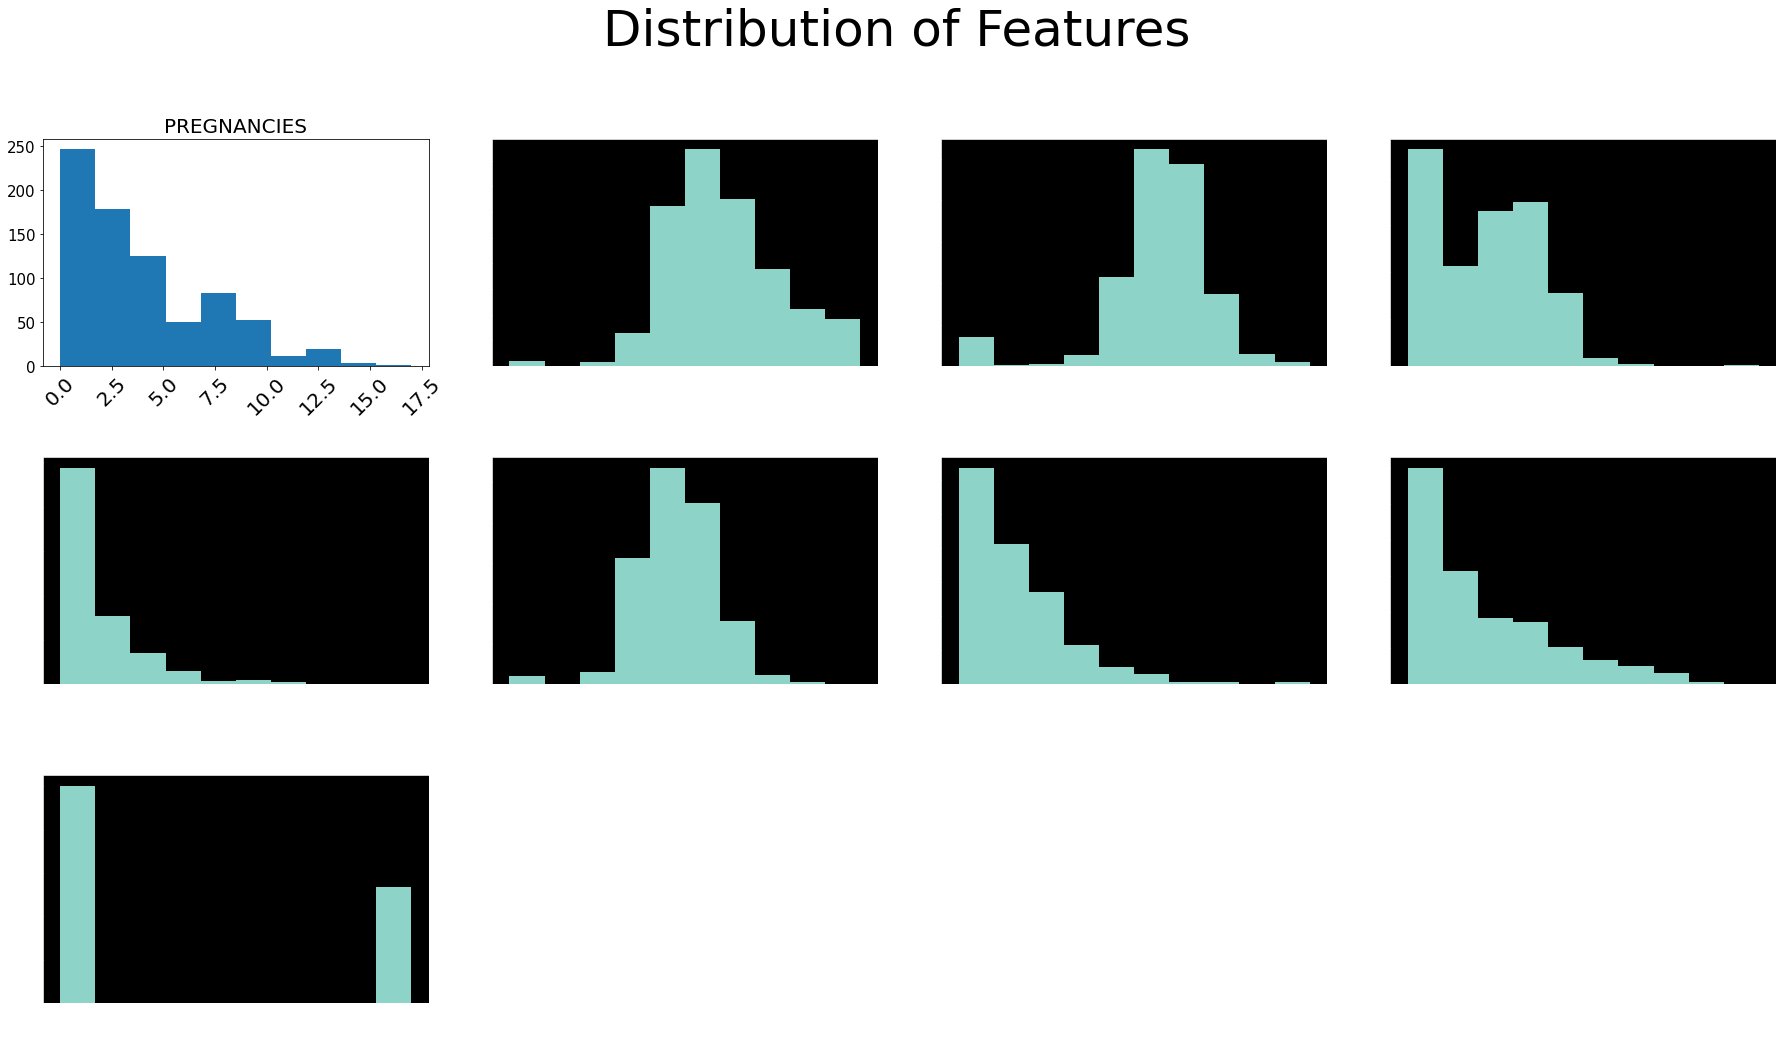

In [12]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Check For Null Values

In [13]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


## UDF 
### a ) Change Column Name and Data of Target Variable(OutCome)  

In [14]:
from pyspark.sql.functions import udf
y_udf = udf(lambda y: "No" if y==0 else "yes", StringType())

df=df.withColumn("HasDiabities", y_udf('OutCome')).drop("OutCome")

### b) Create a new column - Age Groups

In [15]:
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

education_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", education_udf('Age'))

### Age Groups Distribution

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = df.select(['Age_udf','Glucose']).\
   groupBy('Age_udf').\
       agg(F.count('Glucose').alias('UserCount'),
           F.mean('Glucose').alias('Glucose_AVG'),
           F.min('Glucose').alias('Glucose_MIN'),
           F.max('Glucose').alias('Glucose_MAX')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       drop(col('total')).sort(desc("Percent"))

In [17]:
tab.show()

+-----------------+---------+------------------+-----------+-----------+------------------+
|          Age_udf|UserCount|       Glucose_AVG|Glucose_MIN|Glucose_MAX|           Percent|
+-----------------+---------+------------------+-----------+-----------+------------------+
|         Under 25|      267|110.71910112359551|          0|        199|         34.765625|
|Between 25 and 35|      231|121.67099567099567|         71|        198|         30.078125|
|Between 36 and 49|      181|125.74033149171271|          0|        197|23.567708333333332|
|          Over 50|       89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+---------+------------------+-----------+-----------+------------------+



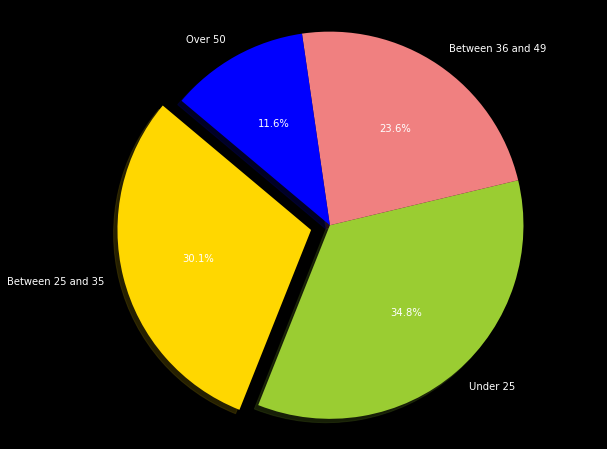

In [18]:
# Data to plot
labels = list(tab.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 )  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Pearson Correlation

In [19]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [20]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


In [21]:
df=df.drop("Age")

In [22]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|HasDiabities|          Age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627|         yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351|          No|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672|         yes|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167|          No|         Under 25|
+-----------+-------+-------------+-------------+-------+----+------------------------+------------+-----------------+
only showing top 4 rows



# Prepare Data for Machine Learning

## First Method 
### Step by Step apply 5 Estimators and Transformers and create new data frames

## a) StringIndexer

In [23]:
df2=df
df3=df

In [24]:
stringIndexer = StringIndexer()\
                 .setInputCol ("Age_udf")\
                 .setOutputCol ("Age_udfIndex")

Age_udfIndex_model=stringIndexer.fit(df2)
Age_udfIndex_df=Age_udfIndex_model.transform(df2)
Age_udfIndex_df.toPandas().head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0
5,5,116,74,0,0,25.6,0.201,No,Between 25 and 35,1.0
6,3,78,50,32,88,31.0,0.248,yes,Between 25 and 35,1.0
7,10,115,0,0,0,35.3,0.134,No,Between 25 and 35,1.0
8,2,197,70,45,543,30.5,0.158,yes,Over 50,3.0
9,8,125,96,0,0,0.0,0.232,yes,Over 50,3.0


In [26]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

## b) OneHotEncoderEstimator

In [27]:
encoder = OneHotEncoder()\
         .setInputCols (["Age_udfIndex"])\
         .setOutputCols (["Age_encoded"])

encoder_model=encoder.fit(Age_udfIndex_df)
encoder_df=encoder_model.transform(Age_udfIndex_df)

encoder_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)"
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)"
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


## c) VectorAssembler

In [29]:
assembler = VectorAssembler()\
         .setInputCols (["Age_encoded","Pregnancies","Glucose",
                         "BloodPressure","SkinThickness",\
                         "Insulin","BMI","DiabetesPedigreeFunction"])\
         .setOutputCol ("vectorized_features")
        

assembler_df=assembler.transform(encoder_df)
assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]"
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]"
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]"
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]"
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]"


## d) LabelIndexer

In [30]:
label_indexer = StringIndexer()\
         .setInputCol ("HasDiabities")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("HasDiabities","label").toPandas().head()

,HasDiabities,label
0,yes,1.0
1,No,0.0
2,yes,1.0
3,No,0.0
4,yes,1.0


# e) StandardScaler

In [31]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35...","[0.0, 0.0, 0.0, 1.7806383732194306, ..."
1,"[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29....","[0.0, 2.1791401333367157, 0.0, 0.296..."
2,"[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0....","[0.0, 2.1791401333367157, 0.0, 2.374..."
3,"[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....","[2.098474993842542, 0.0, 0.0, 0.2967..."
4,"[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...","[0.0, 2.1791401333367157, 0.0, 0.0, ..."


## Second Method 

##  Create 5 Transformers / Estimators but apply all of them in a pipeline

In [32]:
pipeline_stages=Pipeline()\
                .setStages([stringIndexer,encoder,assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df3)
pipeline_df=pipeline_model.transform(df3)

In [33]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf,Age_udfIndex,Age_encoded,vectorized_features,label,features
0,6,148,72,35,0,33.6,0.627,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35...",1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, ..."
1,1,85,66,29,0,26.6,0.351,No,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29....",0.0,"[0.0, 2.1791401333367157, 0.0, 0.296..."
2,8,183,64,0,0,23.3,0.672,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0....",1.0,"[0.0, 2.1791401333367157, 0.0, 2.374..."
3,1,89,66,23,94,28.1,0.167,No,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....",0.0,"[2.098474993842542, 0.0, 0.0, 0.2967..."
4,0,137,40,35,168,43.1,2.288,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...",1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, ..."


## Third Method


In [35]:
categoricalColumns = ['Age_udf']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'HasDiabities', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["Pregnancies", 'Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [36]:
cols = df.columns

In [37]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'HasDiabities',
 'Age_udf']

In [38]:
stages

[StringIndexer_46ddfef8a91c,
 OneHotEncoder_e1e434e0b048,
 StringIndexer_14bde806a5b2,
 VectorAssembler_318168301ce1,
 StandardScaler_db0b9efcdac5]

In [39]:

cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- HasDiabities: string (nullable = true)
 |-- Age_udf: string (nullable = true)



In [40]:
df.toPandas().head()

,label,features,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HasDiabities,Age_udf
0,1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, ...",6,148,72,35,0,33.6,0.627,yes,Over 50
1,0.0,"[0.0, 2.1791401333367157, 0.0, 0.296...",1,85,66,29,0,26.6,0.351,No,Between 25 and 35
2,1.0,"[0.0, 2.1791401333367157, 0.0, 2.374...",8,183,64,0,0,23.3,0.672,yes,Between 25 and 35
3,0.0,"[2.098474993842542, 0.0, 0.0, 0.2967...",1,89,66,23,94,28.1,0.167,No,Under 25
4,1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, ...",0,137,40,35,168,43.1,2.288,yes,Between 25 and 35


# Train / Test Split

In [41]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 617
Test Dataset Count: 151


In [42]:
train.groupby("HasDiabities").count().show()

+------------+-----+
|HasDiabities|count|
+------------+-----+
|          No|  399|
|         yes|  218|
+------------+-----+



# Model Training

In [43]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.098474993842542, 0.0, 0.0, 0.5935...","[2.4977756062725556, -2.497775606272...",0.0,"[0.9239857345156194, 0.0760142654843..."
1,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[3.282061280081577, -3.282061280081577]",0.0,"[0.9638082537794805, 0.0361917462205..."
2,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[2.458696368114203, -2.458696368114203]",0.0,"[0.9211950780039839, 0.0788049219960..."
3,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[3.0201779962149446, -3.020177996214...",0.0,"[0.9534774217192942, 0.0465225782807..."
4,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 2...","[4.638984856378516, -4.638984856378516]",0.0,"[0.990425059246924, 0.00957494075307..."


# Confusion Matrix

In [44]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22 28]
 [10 91]]


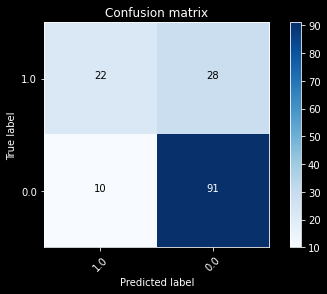

In [45]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Accuracy

In [46]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7483443708609272


C:\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


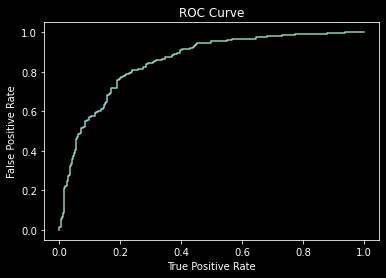

Training set areaUnderROC: 0.853567404750406


In [47]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# Model Evaluation

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7916831683168316
